# Jigsaw Unintended Bias in Toxicity Classification

In [2]:
import findspark
findspark.init()

import pyspark
from pyspark.sql import SparkSession

spark = SparkSession.builder \
.master("local") \
.master("local[*]") \
.appName("Jigsaw Unintended Bias in Toxicity Classification") \
.config("spark.driver.memory", "8g") \
.config("spark.executor.memory", "8g") \
.config("spark.some.config.option", "some-value") \
.getOrCreate()


Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
25/11/21 05:10:24 WARN Utils: Your hostname, mti850vm, resolves to a loopback address: 127.0.1.1; using 10.0.2.15 instead (on interface enp0s8)
25/11/21 05:10:24 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/11/21 05:10:24 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
import matplotlib.pyplot as plt
from pyspark.sql.functions import isnan

from pyspark.sql.functions import udf, regexp_replace, lower, col, when
from pyspark.sql.types import ArrayType, StringType
from pyspark.ml import Pipeline
from pyspark.ml.feature import Tokenizer, StopWordsRemover, SQLTransformer
from pyspark.ml.evaluation import BinaryClassificationEvaluator

import nltk
nltk.download("wordnet")
nltk.download("omw-1.4")
from nltk.stem import WordNetLemmatizer

import os
from pyspark.ml import PipelineModel

[nltk_data] Downloading package wordnet to /home/mti850/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/mti850/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


## 0. Chargement et inspection des données

In [4]:
#train = spark.read.csv('train.csv', header=True, inferSchema=True)
train = spark.read.csv('/home/mti850/Desktop/Github/MTI850-Final_Project/jigsaw-unintended-bias-in-toxicity-classification/train.csv', header=True, inferSchema=True)
train.select("id", "target", "comment_text").show(5, truncate=False) # pas toutes les colonnes sinon illible 

+-----+------------------+------------------------------------------------------------------------------------------------------------------+
|id   |target            |comment_text                                                                                                      |
+-----+------------------+------------------------------------------------------------------------------------------------------------------+
|59848|0.0               |This is so cool. It's like, 'would you want your mother to read this??' Really great idea, well done!             |
|59849|0.0               |Thank you!! This would make my life a lot less anxiety-inducing. Keep it up, and don't let anyone get in your way!|
|59852|0.0               |This is such an urgent design problem; kudos to you for taking it on. Very impressive!                            |
|59855|0.0               |Is this something I'll be able to install on my site? When will you be releasing it?                              |
|59856

In [5]:
train.printSchema()

root
 |-- id: string (nullable = true)
 |-- target: string (nullable = true)
 |-- comment_text: string (nullable = true)
 |-- severe_toxicity: string (nullable = true)
 |-- obscene: string (nullable = true)
 |-- identity_attack: string (nullable = true)
 |-- insult: string (nullable = true)
 |-- threat: string (nullable = true)
 |-- asian: string (nullable = true)
 |-- atheist: string (nullable = true)
 |-- bisexual: string (nullable = true)
 |-- black: string (nullable = true)
 |-- buddhist: string (nullable = true)
 |-- christian: string (nullable = true)
 |-- female: string (nullable = true)
 |-- heterosexual: string (nullable = true)
 |-- hindu: string (nullable = true)
 |-- homosexual_gay_or_lesbian: string (nullable = true)
 |-- intellectual_or_learning_disability: string (nullable = true)
 |-- jewish: string (nullable = true)
 |-- latino: string (nullable = true)
 |-- male: string (nullable = true)
 |-- muslim: string (nullable = true)
 |-- other_disability: string (nullable = t

In [6]:
print(f"nombre de lignes : {train.count()}")
print(f"nombre de colonnes : {len(train.columns)}")
train.describe(['target', 'severe_toxicity', 'obscene', 'insult']).show()

nombre de lignes : 3053644
nombre de colonnes : 45


25/11/21 05:10:47 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
[Stage 6:==================================================>        (6 + 1) / 7]

+-------+-----------------+------------------+-------------------+------------------+
|summary|           target|   severe_toxicity|            obscene|            insult|
+-------+-----------------+------------------+-------------------+------------------+
|  count|          2675011|           1952476|            1884541|           1599964|
|   mean| 1.39617704209127|0.5229622220223501|0.27979058176251326|0.1588871465791632|
| stddev|95.57281390041796| 29.97467979690922| 20.856200441619187|12.442404028199363|
|    min|               \t|                  |                   |                  |
|    max|              😀"|        … you know|   … heroes three."|            ”. Wow|
+-------+-----------------+------------------+-------------------+------------------+



Problème : on a des données non numériques dans ces colonnes --> données mal parsées --> on vérifie dans le schéma : type string au lieu d'un type numérique, ce qui confirme notre intuition

In [7]:
train = (
    spark.read.format("csv")
    .option("header", True)
    .option("inferSchema", True)
    .option("multiLine", True) # commentaires multilignes
    .option("escape", "\"") # les " internes à un comment ne ferment pas le champ
    #.load("train.csv")
    .load("/home/mti850/Desktop/Github/MTI850-Final_Project/jigsaw-unintended-bias-in-toxicity-classification/train.csv")
)

In [8]:
train.printSchema()

root
 |-- id: integer (nullable = true)
 |-- target: double (nullable = true)
 |-- comment_text: string (nullable = true)
 |-- severe_toxicity: double (nullable = true)
 |-- obscene: double (nullable = true)
 |-- identity_attack: double (nullable = true)
 |-- insult: double (nullable = true)
 |-- threat: double (nullable = true)
 |-- asian: double (nullable = true)
 |-- atheist: double (nullable = true)
 |-- bisexual: double (nullable = true)
 |-- black: double (nullable = true)
 |-- buddhist: double (nullable = true)
 |-- christian: double (nullable = true)
 |-- female: double (nullable = true)
 |-- heterosexual: double (nullable = true)
 |-- hindu: double (nullable = true)
 |-- homosexual_gay_or_lesbian: double (nullable = true)
 |-- intellectual_or_learning_disability: double (nullable = true)
 |-- jewish: double (nullable = true)
 |-- latino: double (nullable = true)
 |-- male: double (nullable = true)
 |-- muslim: double (nullable = true)
 |-- other_disability: double (nullable = 

In [9]:
print(f"nombre de lignes : {train.count()}")
print(f"nombre de colonnes : {len(train.columns)}")
train.describe(['target', 'severe_toxicity', 'obscene', 'insult']).show()

nombre de lignes : 1804874
nombre de colonnes : 45


[Stage 14:>                                                         (0 + 1) / 1]

+-------+-------------------+--------------------+--------------------+-------------------+
|summary|             target|     severe_toxicity|             obscene|             insult|
+-------+-------------------+--------------------+--------------------+-------------------+
|  count|            1804874|             1804874|             1804874|            1804874|
|   mean|0.10301729306264126|0.004582098790397937|0.013877209195019816|0.08115273414475882|
| stddev|0.19707574479033887| 0.02286128244247058|  0.0646041914397229|0.17606571372957508|
|    min|                0.0|                 0.0|                 0.0|                0.0|
|    max|                1.0|                 1.0|                 1.0|                1.0|
+-------+-------------------+--------------------+--------------------+-------------------+



In [10]:
train.limit(20).toPandas().head()

,id,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,...,article_id,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
0,59848,0.000000,"This is so cool. It's like, 'would you want yo...",0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
1,59849,0.000000,Thank you!! This would make my life a lot less...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
2,59852,0.000000,This is such an urgent design problem; kudos t...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
3,59855,0.000000,Is this something I'll be able to install on m...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
4,59856,0.893617,haha you guys are a bunch of losers.,0.021277,0.0,0.021277,0.87234,0.0,0.0,0.0,...,2006,rejected,0,0,0,1,0,0.0,4,47


In [11]:
def describe_col(spark_df, col, bins = 50):
    """
    Affiche la distribution d'une col numerique + nb valeurs manquantes
    """
    data = spark_df.select(col).toPandas()
    
    plt.figure(figsize=(8, 5))
    plt.hist(data[col], bins=bins, edgecolor='black')
    plt.title(f"Distribution de '{col}'")
    plt.xlabel(col)
    plt.ylabel("Fréquence")
    plt.grid(True, alpha=0.3)
    plt.show()

    tot = spark_df.count()
    missing = spark_df.filter((spark_df[col].isNull()) | (isnan(spark_df[col]))).count()
    missing_pct = (missing / tot) * 100
    print(f"Valeurs manquantes : {missing} / {tot} ({missing_pct:.2f}%)")

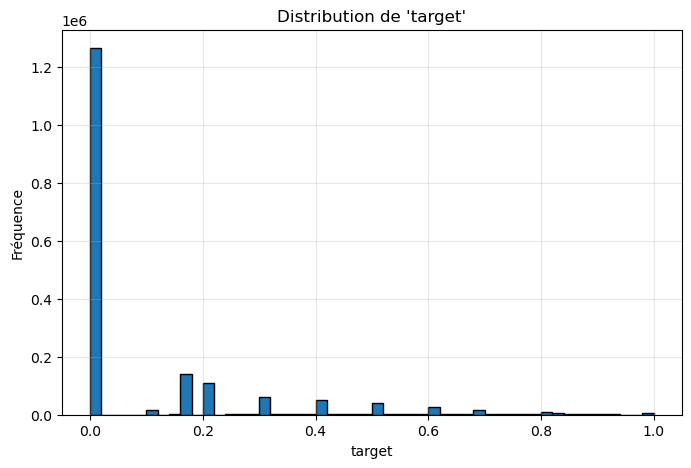

[Stage 22:>                                                         (0 + 1) / 1]

Valeurs manquantes : 0 / 1804874 (0.00%)


In [12]:
describe_col(train, "target")

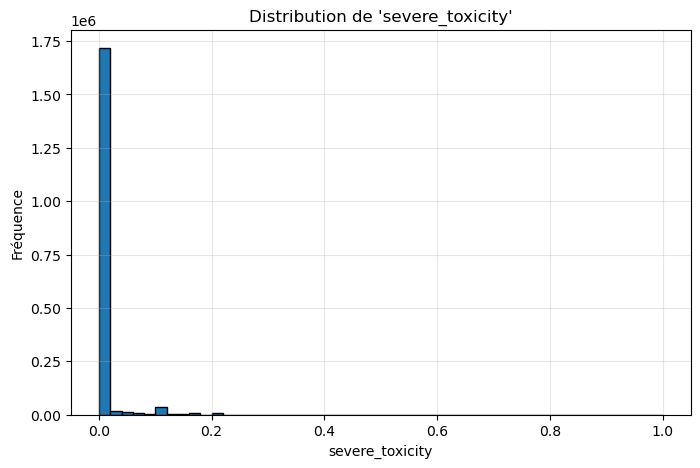

[Stage 29:>                                                         (0 + 1) / 1]

Valeurs manquantes : 0 / 1804874 (0.00%)


In [13]:
describe_col(train, "severe_toxicity")

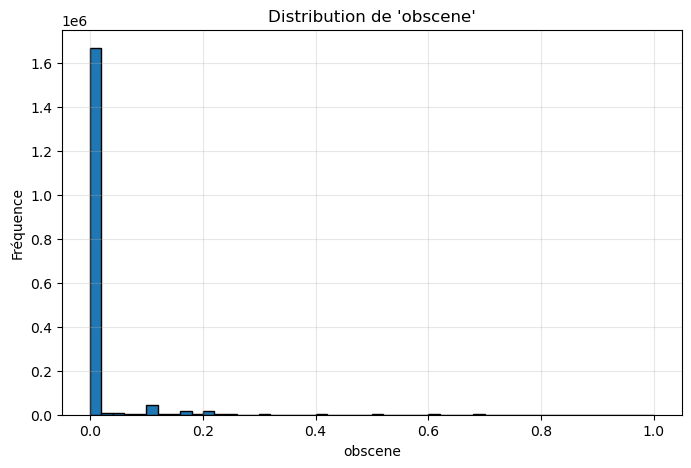

[Stage 36:>                                                         (0 + 1) / 1]

Valeurs manquantes : 0 / 1804874 (0.00%)


In [14]:
describe_col(train, "obscene")

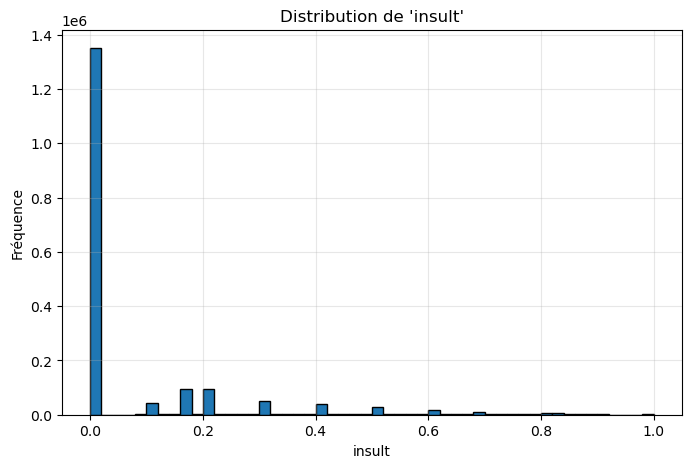

[Stage 43:>                                                         (0 + 1) / 1]

Valeurs manquantes : 0 / 1804874 (0.00%)


In [15]:
describe_col(train, "insult")

A faire encore dans cette partie :
- étudier les distributions des autres features

# 1. Approche Classique Spark ML sur la colonne "comments"

--> utilisation de fonctions UDF afin que le traitement reste distribué sur les workers (pas d'utilisation de pandas sauf pour l'affichage d'un échantillon des données !!!

--> on fait tout le prétraitement dans spark

--> Encapsulation dans un pipeline --> structure robuste et modulaire


## 1.1 Prétraitement

### 1.1.1 Définition d'un Transformer SPark ML pour la lemmatisation

Il n'y a pas d'objet Mlib natif dans Spark ML permettant de faire une lemmatisation.
Pour pouvoir encapsuler cette étape dans le pipeline spark, nous ne pouvons pas utiliser une UDF python classique.
Nous avons donc créé un Transformer Spark ML, compatible avec le pipeline Spark

In [16]:
from pyspark.ml import Transformer
from pyspark.ml.util import DefaultParamsReadable, DefaultParamsWritable
from pyspark.sql.functions import udf
from pyspark.sql.types import ArrayType, StringType

# Il n'y a pas d'objet Mlib natif dans Spark ML permettant de faire une lemmatisation.
# Pour pouvoir encapsuler cette étape dans le pipeline spark, nous ne pouvons pas utiliser une UDF python classique
# Nous avons donc créé un Transformer Spark ML, compatible avec le pipeline Spark

lemm = WordNetLemmatizer()

class Lemmatizer(Transformer, DefaultParamsReadable, DefaultParamsWritable):

    def __init__(self, inputCol="tokens", outputCol="lemmatized"):
        super(Lemmatizer, self).__init__()
        self.inputCol = inputCol
        self.outputCol = outputCol

    def _transform(self, df):
        lemm = WordNetLemmatizer()
        lemm_udf = udf(lambda tokens: [lemm.lemmatize(w) for w in tokens], ArrayType(StringType()))
        return df.withColumn(self.outputCol, lemm_udf(df[self.inputCol]))


### 1.1.2 Définition de la fonction Preprocess

In [17]:
def preprocess(df, limit=None, debug=False):
    """
    Nettoyage (tout en minuscule + suppression de tous les caractères non alphabétiques) --> tokenisation --> stopwords --> lemmatisation → conversion de target en binaire
    Retourne un df contenant : tokens, target, label
    """
    # Pour choisir la taille de l'échantillon du dataset
    if limit:
        df = df.limit(limit)

    # Nettoyage du texte (Spark SQL + regex)
    regex_cleaner = SQLTransformer(
        statement="""
            SELECT *,
            regexp_replace(lower(comment_text), '[^a-z ]', '') AS clean_text
            FROM __THIS__
        """
    )

    tokenizer = Tokenizer(inputCol="clean_text", outputCol="words")
    remover = StopWordsRemover(inputCol="words", outputCol="filtered")
    lemmatizer = Lemmatizer(inputCol="filtered", outputCol="tokens")

    # Pipeline de preprocessing 
    preprocess_pipeline = Pipeline(stages=[
        regex_cleaner,
        tokenizer,
        remover,
        lemmatizer
    ])

    df_prep = preprocess_pipeline.fit(df).transform(df)

    # Target --> binarisation
    # Spark ML reglog = classif binaire --> on doit convertir la colonne target en binaire pour le modèle baseline, meme si cela nous fait perdre de l'information
    df_prep = df_prep.withColumn(
        "label",
        when(col("target") >= 0.5, 1).otherwise(0)
    )

    # Pour voir les différentes étapes du préprocessing
    if (debug == True):

        print("\n>>> AFFICHAGE DES DIFFERENTES ETAPES DU PREPROCESSING")
        
        print("\n# 1) regex_cleaner")
        df1_debug = regex_cleaner.transform(train)
        df1_debug.select("clean_text").show(5, truncate=False)
        
        print("\n# 2) tokenizer")
        df2_debug = tokenizer.transform(df1_debug)
        df2_debug.select("words").show(5, truncate=False)
        
        print("\n# 3) stopwords remover")
        df3_debug = remover.transform(df2_debug)
        df3_debug.select("filtered").show(5, truncate=False)
        
        print("\n# 4) lemmatizer (UDF)")
        df4_debug = lemmatizer.transform(df3_debug)
        df4_debug.select("tokens").show(5, truncate=False)

        print("------------------------------------------------------")


        
    return df_prep.select("tokens", "target", "label")

## 1.2 Split des données 

3 sous ensembles : train, test et val pour l'apprentissage des hyperparamètres

In [18]:
def split_data(df, seed=50):
    """
    Split en train / validation / test (70 / 15 / 15)
    """
    return df.randomSplit([0.7, 0.15, 0.15], seed=seed)



## 1.3 Vectorisation et Modélisation

3 méthodes à tester :

- CountVectorizer
- TF-IDF
- Word2Vec

Modèle baseline : Regression Logistique

### 1.3.1 Pipeline baseline : CountVectorizer + IDF + RegLog

In [19]:
from pyspark.ml.feature import CountVectorizer, IDF
from pyspark.ml.classification import LogisticRegression

def build_pipeline():
    """
    Pipeline ML complet : TF-IDF --> LogisticRegression
    """
    # transforme les tokens en vecteurs numériques ; listes --> sparce vector
    cv = CountVectorizer(
        inputCol="tokens",
        outputCol="raw_features",
        vocabSize=100000, #largeur voc
        minDF=5 # on garde que quand dans 5 commentaires ou +, pour réduire le bruit
    )

    idf = IDF(inputCol="raw_features", outputCol="features")

    lr = LogisticRegression(
        featuresCol="features",
        labelCol="label",
        maxIter=50,
        regParam=0.0
    )

    return Pipeline(stages=[cv, idf, lr])

## Main code

In [20]:
#PREPROCESSED_PATH = "data/preprocessed.parquet"
#MODEL_PATH = "models/tfidf_logreg"

PREPROCESSED_PATH = "/home/mti850/Desktop/Github/MTI850-Final_Project/jigsaw-unintended-bias-in-toxicity-classification/data/preprocessed_all2_20subdiv.parquet" 
MODEL_PATH = "/home/mti850/Desktop/Github/MTI850-Final_Project/models/tfidf_100k_20subdiv_logreg"


SAVE_PREPROCESSED = True  # mettre True pour sauvegarder le preprocessing dans un parquet
LOAD_PREPROCESSED = False  # mettre True pour charger un fichier existant

SAVE_MODEL = True  # meme chose        
LOAD_MODEL = False 

In [47]:
import time
# 1. Prétraitement (ou chargement)
start_time_1 = time.time() # DÉBUT CHRONO 1
if LOAD_PREPROCESSED and os.path.exists(PREPROCESSED_PATH):
    print(f"Chargement des données prétraitées depuis : {PREPROCESSED_PATH}")
    df_clean = spark.read.parquet(PREPROCESSED_PATH)

else:
    print("Prétraitement...")
    df_clean = preprocess(train, limit=10000000, debug=True)   # debug = True pour afficher toutes les étapes

    if SAVE_PREPROCESSED:
        print(f"Sauvegarde des données prétraitées --> {PREPROCESSED_PATH}")
        #df_clean.write.mode("overwrite").parquet(PREPROCESSED_PATH)
        df_clean.repartition(20).write.mode("overwrite").parquet(PREPROCESSED_PATH)

end_time_1 = time.time() # FIN CHRONO 1
print(f">>>Prétraitement OK (Durée: {end_time_1 - start_time_1:.2f} secondes)")
#print("\n>>>Prétraitement OK")
df_clean.show(5, truncate=False)

# 2. Split des données
start_time_2 = time.time() # DÉBUT CHRONO 2
train_df, val_df, test_df = split_data(df_clean)
end_time_2 = time.time() # FIN CHRONO 2
print(f">>> Split OK (Durée: {end_time_2 - start_time_2:.2f} secondes)")
#start_time_3 = time.time() # DÉBUT CHRONO 3
#print(f"Train = {train_df.count()} | Val = {val_df.count()} | Test = {test_df.count()}")
#end_time_3 = time.time() # FIN CHRONO 3
#print(f">>> Comptage OK (Durée: {end_time_3 - start_time_3:.2f} secondes)")

# 3. Pipeline
start_time_4 = time.time() # DÉBUT CHRONO 4
pipeline = build_pipeline()
end_time_4 = time.time() # FIN CHRONO 4
print(f">>> Pipeline OK (Durée: {end_time_4 - start_time_4:.2f} secondes)")
"""
# 4. Entrainement (ou chargement) du modèle
if LOAD_MODEL and os.path.exists(MODEL_PATH):
    print(f"Chargement du modèle existant : {MODEL_PATH}")
    model = PipelineModel.load(MODEL_PATH)

else:
    print("Entrainement du modèle...")
    start_time_5 = time.time() # DÉBUT CHRONO 5
    model = pipeline.fit(train_df)
    end_time_5 = time.time() # FIN CHRONO 5
    print(f">>> Training OK (Durée: {end_time_5 - start_time_5:.2f} secondes)")

    print(">>> Modèle entraîné OK")

    if SAVE_MODEL:
        print(f"Sauvegarde du modèle --> {MODEL_PATH}")
        model.write().overwrite().save(MODEL_PATH)

# 5. Test du modèle
preds = model.transform(test_df)
print("\n>>> Prédictions OK")
preds.select("tokens", "target", "label", "probability", "prediction").show(truncate=40)

# 6. Evaluation ROC-AUC
evaluator = BinaryClassificationEvaluator(
    labelCol="label",
    rawPredictionCol="rawPrediction",
    metricName="areaUnderROC"
)

auc = evaluator.evaluate(preds)
print(f"\n>>> Baseline ROC-AUC = {auc:.4f}")

"""

Prétraitement...

>>> AFFICHAGE DES DIFFERENTES ETAPES DU PREPROCESSING

# 1) regex_cleaner
+-----------------------------------------------------------------------------------------------------------+
|clean_text                                                                                                 |
+-----------------------------------------------------------------------------------------------------------+
|this is so cool its like would you want your mother to read this really great idea well done               |
|thank you this would make my life a lot less anxietyinducing keep it up and dont let anyone get in your way|
|this is such an urgent design problem kudos to you for taking it on very impressive                        |
|is this something ill be able to install on my site when will you be releasing it                          |
|haha you guys are a bunch of losers                                                                        |
+---------------------------

+----------------------------------------------------------------------------------+
|tokens                                                                            |
+----------------------------------------------------------------------------------+
|[cool, like, want, mother, read, really, great, idea, well, done]                 |
|[thank, make, life, lot, less, anxietyinducing, keep, dont, let, anyone, get, way]|
|[urgent, design, problem, kudos, taking, impressive]                              |
|[something, ill, able, install, site, releasing]                                  |
|[haha, guy, bunch, loser]                                                         |
+----------------------------------------------------------------------------------+
only showing top 5 rows
------------------------------------------------------
Sauvegarde des données prétraitées --> /home/mti850/Desktop/Github/MTI850-Final_Project/jigsaw-unintended-bias-in-toxicity-classification/data/preprocessed_

>>>Prétraitement OK (Durée: 91.42 secondes)
+----------------------------------------------------------------------------------+------------------+-----+
|tokens                                                                            |target            |label|
+----------------------------------------------------------------------------------+------------------+-----+
|[cool, like, want, mother, read, really, great, idea, well, done]                 |0.0               |0    |
|[thank, make, life, lot, less, anxietyinducing, keep, dont, let, anyone, get, way]|0.0               |0    |
|[urgent, design, problem, kudos, taking, impressive]                              |0.0               |0    |
|[something, ill, able, install, site, releasing]                                  |0.0               |0    |
|[haha, guy, bunch, loser]                                                         |0.8936170212765957|1    |
+---------------------------------------------------------------------------

'\n# 4. Entrainement (ou chargement) du modèle\nif LOAD_MODEL and os.path.exists(MODEL_PATH):\n    print(f"Chargement du modèle existant : {MODEL_PATH}")\n    model = PipelineModel.load(MODEL_PATH)\n\nelse:\n    print("Entrainement du modèle...")\n    start_time_5 = time.time() # DÉBUT CHRONO 5\n    model = pipeline.fit(train_df)\n    end_time_5 = time.time() # FIN CHRONO 5\n    print(f">>> Training OK (Durée: {end_time_5 - start_time_5:.2f} secondes)")\n\n    print(">>> Modèle entraîné OK")\n\n    if SAVE_MODEL:\n        print(f"Sauvegarde du modèle --> {MODEL_PATH}")\n        model.write().overwrite().save(MODEL_PATH)\n\n# 5. Test du modèle\npreds = model.transform(test_df)\nprint("\n>>> Prédictions OK")\npreds.select("tokens", "target", "label", "probability", "prediction").show(truncate=40)\n\n# 6. Evaluation ROC-AUC\nevaluator = BinaryClassificationEvaluator(\n    labelCol="label",\n    rawPredictionCol="rawPrediction",\n    metricName="areaUnderROC"\n)\n\nauc = evaluator.evaluate

### Pour sauvegarder le modèle ou les données preprocessed  

Cette cellule peut être executée à nimporte quel moment pour sauvegarder un modèle/un df de data preprocessed

In [19]:
# print(f"Sauvegarde des données prétraitées --> {PREPROCESSED_PATH}")
# df_clean.write.mode("overwrite").parquet(PREPROCESSED_PATH)

# print(f"Sauvegarde du modèle --> {MODEL_PATH}")
# model.write().overwrite().save(MODEL_PATH)

## 1.3 Optimisation des hyperparamètres

## 1.4 Optimisation et validation


# 2. Analyse du biais et métriques d’équité


# 3. Interprétabilité et robustesse


# 4. Approche moderne : Transformers (BERT)


L'idée était ici d'utiliser les modèles BERT pour le traitement des données, via la surcouche Sparknlp. Malgré un downgrade vers Spark 3.5 pour des soucis de compatibilité (Spark 4 et Scala 2.12 ne sont pas compatibles), cela n'a pas suffit, notamment à cause du fait d'utiliser une VM linux sur une architecture mac ARM. Le choix a donc été fait de passer outre Sparknlp et d'utiliser Hugging Face.

Au besoin pour l'installation des librairies

In [1]:
# Installation des librairies Python nécessaires pour BERT
!pip install datasets transformers torch onnx onnxruntime tf2onnx
# Installation de la dépendance pour le Trainer Hugging Face
!pip install accelerate -U

Configuration spécifique de la SparkSession pour SparkNLP 

In [2]:
import os
import sys
import findspark

# 1. Initialisation via findspark (pour retrouver le Spark 4 dans /opt/spark)
findspark.init()

import pyspark
from pyspark.sql import SparkSession

# 2. Configuration Optimisée pour BERT sur Spark 4
# On garde les optimisations mémoire (12Go) et Arrow (Vitesse)
spark = SparkSession.builder \
    .appName("Jigsaw BERT Turbo (Spark 4)") \
    .master("local[*]") \
    .config("spark.driver.memory", "12g") \
    .config("spark.driver.maxResultSize", "2g") \
    .config("spark.sql.execution.arrow.pyspark.enabled", "true") \
    .getOrCreate()

print(f"Session Spark active.")
print(f"Spark Version : {spark.version}") 
# Doit afficher une version 4.x.x
print(f"CPUs disponibles : {os.cpu_count()}")

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
25/11/21 20:00:11 WARN Utils: Your hostname, mti850vm, resolves to a loopback address: 127.0.1.1; using 10.0.2.15 instead (on interface enp0s8)
25/11/21 20:00:11 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/11/21 20:00:12 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Session Spark active.
Spark Version : 4.0.0
CPUs disponibles : 6


Allocation de 12g au driver afin de supporter le passage toPandas.
Activation de Apache Arrow pour accélérer la conversion toPandas().

Chargement des données brutes pour le pré-traitement pour BERT
Gestion des retours à la ligne. On force la conversion de 'target' en float pour éviter les erreurs avec le texte corrompu qui pourrait s'y trouver.
On limite la taille de l'échantillon pour éviter les saturations mémoire.

In [18]:
from pyspark.sql.functions import col, when
import pandas as pd

# --- CONFIGURATION ---
DATA_PATH = '/home/mti850/Desktop/Github/MTI850-Final_Project/jigsaw-unintended-bias-in-toxicity-classification/train.csv'
SAMPLE_SIZE = 100000  # Nombre de lignes pour le Fine-Tuning (ajuster selon votre RAM)

print(f"--- Démarrage de l'extraction ETL ({SAMPLE_SIZE} lignes) ---")

# 1. Chargement des données brutes
# multiLine=True est vital pour les commentaires contenant des sauts de ligne
df_raw = spark.read.csv(DATA_PATH, header=True, inferSchema=True, multiLine=True, escape='"')

# 2. Pipeline de Nettoyage Strict
# On s'assure que 'target' est bien numérique et que le texte n'est pas vide
df_clean = df_raw.select("comment_text", "target") \
    .filter(col("comment_text").isNotNull()) \
    .filter(col("comment_text") != "") \
    .withColumn("target", col("target").cast("float")) \
    .filter(col("target").isNotNull()) \
    .withColumn("label", when(col("target") >= 0.5, 1).otherwise(0))

# 3. Échantillonnage et Conversion Pandas
# C'est ici que les données passent du Cluster (Spark) à la RAM locale (Python)
print("Conversion Spark -> Pandas en cours...")
pdf_sample = df_clean.limit(SAMPLE_SIZE).toPandas()

# Vérification
print(f"Succès ! Dimensions du DataFrame Pandas : {pdf_sample.shape}")
print(pdf_sample.head(10))

--- Démarrage de l'extraction ETL (100000 lignes) ---


Conversion Spark -> Pandas en cours...


Succès ! Dimensions du DataFrame Pandas : (100000, 3)
                                        comment_text    target  label
0  This is so cool. It's like, 'would you want yo...  0.000000      0
1  Thank you!! This would make my life a lot less...  0.000000      0
2  This is such an urgent design problem; kudos t...  0.000000      0
3  Is this something I'll be able to install on m...  0.000000      0
4               haha you guys are a bunch of losers.  0.893617      1
5                               ur a sh*tty comment.  0.666667      1
6                        hahahahahahahahhha suck it.  0.457627      0
7                                FFFFUUUUUUUUUUUUUUU  0.000000      0
8  The ranchers seem motivated by mostly by greed...  0.000000      0
9  It was a great show. Not a combo I'd of expect...  0.000000      0


In [20]:
import shutil
import os
from transformers import DistilBertTokenizer
from datasets import Dataset

# --- CONFIGURATION ---
MODEL_NAME = "distilbert-base-uncased"
SAVE_PATH = "/home/mti850/Desktop/Github/MTI850-Final_Project/jigsaw-unintended-bias-in-toxicity-classification/data/Bert/processed_data_bert_100k_1"
MAX_SHARD_SIZE = "10MB"  # Taille max par fichier pour éviter de saturer la RAM au chargement

print("--- Démarrage du Pré-traitement NLP ---")

# 1. Initialisation du Tokenizer
tokenizer = DistilBertTokenizer.from_pretrained(MODEL_NAME)

def tokenize_function(examples):
    # On tronque à 64 tokens pour accélérer l'entraînement sur CPU (vs 512 par défaut)
    return tokenizer(examples["comment_text"], padding="max_length", truncation=True, max_length=64)

# 2. Conversion en Dataset Hugging Face
hf_dataset = Dataset.from_pandas(pdf_sample)

# 3. Application de la Tokenization (Map)
print("Tokenization en cours...")
tokenized_datasets = hf_dataset.map(tokenize_function, batched=True)

# 4. Nettoyage des colonnes
# On ne garde que ce dont le modèle a besoin : input_ids, attention_mask, label
tokenized_datasets = tokenized_datasets.remove_columns(["comment_text", "target"])
tokenized_datasets.set_format("torch")

# 5. Split Train / Test (80% / 20%)
dataset_dict = tokenized_datasets.train_test_split(test_size=0.2)

# 6. Sauvegarde Optimisée sur le Disque
if os.path.exists(SAVE_PATH):
    print(f"Nettoyage du dossier existant : {SAVE_PATH}")
    shutil.rmtree(SAVE_PATH)

print(f"Sauvegarde des données shardées ({MAX_SHARD_SIZE}) dans '{SAVE_PATH}'...")
dataset_dict.save_to_disk(SAVE_PATH, max_shard_size=MAX_SHARD_SIZE)

print(">>> Terminé ! Données prêtes pour l'entraînement.")

--- Démarrage du Pré-traitement NLP ---
Tokenization en cours...


Map:   0%|          | 0/100000 [00:00<?, ? examples/s]

Sauvegarde des données shardées (10MB) dans '/home/mti850/Desktop/Github/MTI850-Final_Project/jigsaw-unintended-bias-in-toxicity-classification/data/Bert/processed_data_bert_100k_1'...


Saving the dataset (0/3 shards):   0%|          | 0/80000 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/20000 [00:00<?, ? examples/s]

>>> Terminé ! Données prêtes pour l'entraînement.


In [6]:
import time
from transformers import DistilBertForSequenceClassification, Trainer, TrainingArguments

print("Chargement du modèle pré-entraîné...")
model = DistilBertForSequenceClassification.from_pretrained(model_name, num_labels=2)

# Paramètres optimisés pour 6 CPUs et 18Go RAM
training_args = TrainingArguments(
    output_dir="./bert_turbo_results",
    num_train_epochs=1,              # 1 époque suffit souvent pour voir des résultats
    per_device_train_batch_size=16,  # Augmenté grâce à la RAM (plus rapide)
    per_device_eval_batch_size=32,
    use_cpu=True,                    # Force CPU (car pas de GPU dans la VM)
    logging_steps=50,
    save_strategy="no"               # Désactive la sauvegarde intermédiaire pour gagner du temps
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset_split["train"],
    eval_dataset=dataset_split["test"],
)

print(f">>> Démarrage de l'entraînement (Patience...)...")
start_time = time.time()

trainer.train()

print(f">>> Entraînement terminé en {(time.time() - start_time)/60:.2f} minutes.")

Chargement du modèle pré-entraîné...


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


>>> Démarrage de l'entraînement (Patience...)...


Step,Training Loss
50,0.279000
100,0.208000
150,0.217700
200,0.160400
250,0.194100
300,0.182000
350,0.182300
400,0.181400
450,0.180900
500,0.120100


>>> Entraînement terminé en 46.62 minutes.


In [10]:
import torch
import torch.onnx

print("Export du modèle vers le format ONNX...")
onnx_path = "/home/mti850/Desktop/Github/MTI850-Final_Project/models/ONNX/distilbert_optimized.onnx"

# Création d'une fausse entrée pour calibrer le modèle
dummy_input = tokenizer("sample text for export", return_tensors="pt", padding="max_length", max_length=64)

# Export
torch.onnx.export(
    model, 
    (dummy_input["input_ids"], dummy_input["attention_mask"]),
    onnx_path,
    input_names=["input_ids", "attention_mask"],
    output_names=["logits"],
    dynamic_axes={"input_ids": {0: "batch"}, "logits": {0: "batch"}}
)

print(f"Modèle exporté avec succès : {onnx_path}")

Export du modèle vers le format ONNX...


/tmp/ipykernel_6326/3920184671.py:11: UserWarning: # 'dynamic_axes' is not recommended when dynamo=True, and may lead to 'torch._dynamo.exc.UserError: Constraints violated.' Supply the 'dynamic_shapes' argument instead if export is unsuccessful.
  torch.onnx.export(
W1121 16:01:18.504000 6326 site-packages/torch/onnx/_internal/exporter/_registration.py:107] torchvision is not installed. Skipping torchvision::nms


[torch.onnx] Obtain model graph for `DistilBertForSequenceClassification([...]` with `torch.export.export(..., strict=False)`...
[torch.onnx] Obtain model graph for `DistilBertForSequenceClassification([...]` with `torch.export.export(..., strict=False)`... ✅
[torch.onnx] Run decomposition...
[torch.onnx] Run decomposition... ✅
[torch.onnx] Translate the graph into ONNX...
[torch.onnx] Translate the graph into ONNX... ✅
Applied 26 of general pattern rewrite rules.


FileNotFoundError: [Errno 2] No such file or directory: '/home/mti850/Desktop/Github/MTI850-Final_Project/models/ONNX/distilbert_optimized.onnx.data'

In [ ]:
import onnxruntime as ort
import numpy as np
from pyspark.sql.functions import pandas_udf
from pyspark import SparkFiles

# 1. Diffusion du fichier modèle aux workers
spark.sparkContext.addFile(onnx_path)

# 2. Définition de la fonction de prédiction (UDF)
@pandas_udf('double')
def predict_toxicity_bert_onnx(texts: pd.Series) -> pd.Series:
    # Initialisation locale du tokenizer
    # Note : En prod, on diffuse aussi le vocabulaire, ici on le retélécharge c'est plus simple
    local_tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
    
    # Récupération du chemin du modèle sur le worker
    model_file = SparkFiles.get("distilbert_optimized.onnx")
    
    # Configuration session ONNX
    sess_options = ort.SessionOptions()
    sess_options.intra_op_num_threads = 1 # Optimisation CPU
    session = ort.InferenceSession(model_file, sess_options)
    
    # Tokenization vectorisée (batch complet)
    inputs = local_tokenizer(
        texts.tolist(), 
        padding="max_length", 
        truncation=True, 
        max_length=64, 
        return_tensors="np"
    )
    
    # Inférence
    logits = session.run(None, {
        "input_ids": inputs["input_ids"].astype(np.int64),
        "attention_mask": inputs["attention_mask"].astype(np.int64)
    })[0]
    
    # Softmax/Sigmoid pour avoir une probabilité entre 0 et 1
    probs = 1 / (1 + np.exp(-logits[:, 1]))
    return pd.Series(probs)

print("Test de l'inférence distribuée sur des données inconnues...")

# On prend 1000 lignes du dataset original que le modèle n'a PAS utilisées pour s'entrainer
df_test_spark = df_clean.subtract(spark.createDataFrame(pdf_sample)).limit(1000)

# Application du modèle
df_res = df_test_spark.withColumn("score_bert", predict_toxicity_bert_onnx(col("comment_text")))

# Affichage
df_res.select("comment_text", "label", "score_bert").show(10, truncate=60)

# 5. Comparaison et évaluation des modèles

# 6. Amélioration et hybridation

# 7. Soumission Kaggle et documentation